## **Depedencias**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.utils._param_validation import InvalidParameterError

## **Carga de datos**

In [2]:
def importar(problem):
    """
        Args:
            problem: int (numero del problema)
        Return:
            problem_set: df (se encuentra la capacidad del vehiculo para cada probema
            y la ruta de los nodos y la matriz de distancia correspondiente a cada problema)

            nodes: df (se encuentra las coordenadas x y de cada nodo y la demanda)

            distance_matrix: df (distancia entre nodos)

            capacity: capacidad del vehiculo para cada problema

        Esta funcion lee un excel y extrae de un parquet los problemas a resolver.
    """


    problem_set = pd.read_excel('raw_problemset.xlsx')
    nodes = pd.read_parquet(problem_set.loc[problem,'nodes'])
    distance_matrix = pd.read_parquet(problem_set.loc[problem,'distance_matrix'])
    capacity = problem_set.loc[problem,'vehicle_capacity']

    return problem_set,nodes,distance_matrix,capacity


In [3]:
# Cargo los datos necesarios
problem_set,nodes,distance_matrix,capacity = importar(4)

## **Graficar**

In [4]:
def graficar_problema(nodes):
    """
        Args:
            DataFrame nodes
        Return:
            None

        Esta funcion esta hecha para graficar los nodos aun sin clusterizar.
    """

    loc_x_nodes = nodes['x'][1:]
    loc_y_nodes = nodes['y'][1:]
    loc_x_depot = nodes['x'][0]
    loc_y_depot = nodes['y'][0]
    plt.figure(figsize=(10,4.5),facecolor='#2C2E2F')
    ax = plt.gca()
    ax.set_facecolor((0.11, 0.11, 0.11))
    plt.tick_params(axis='x', colors='dodgerblue')
    plt.tick_params(axis='y', colors='dodgerblue')
    plt.scatter(loc_x_nodes,loc_y_nodes,color='purple',marker='v')
    plt.scatter(loc_x_depot,loc_y_depot,color='red',marker='D')

    plt.annotate("Depot",(loc_x_depot+1,loc_y_depot-3),color='white')

In [5]:
def graficar_clusters(nodes,labels):
    """
        Args: 
            Dataframe nodes, np.Array labels
        Returns:
            None
            
        Esta funcion esta hecha para graficar los clusters especificamente.
    """
    plt.figure(figsize=(10,4.5),facecolor='#2C2E2F')
    ax = plt.gca()
    ax.set_facecolor((0.11, 0.11, 0.11))
    plt.tick_params(axis='x', colors='dodgerblue')
    plt.tick_params(axis='y', colors='dodgerblue')
    colors = plt.cm.Spectral(np.linspace(0, 1, len(np.unique(labels))))
    for i in range(len(nodes)):
        if i != 0:
            plt.scatter(nodes['x'][i], nodes['y'][i], color=colors[labels[i]],marker='v')
        else:
            plt.scatter(nodes['x'][i], nodes['y'][i], color='red',marker='D')

    plt.annotate("Depot",(nodes['x'][0]+1,nodes['y'][0]-3),color='white')
    plt.show


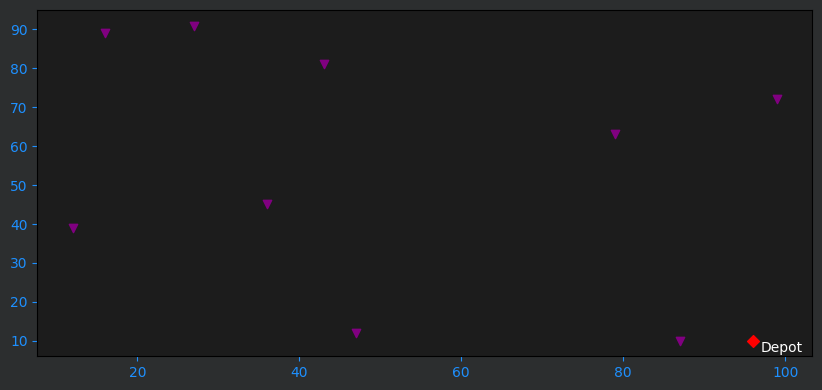

In [6]:
graficar_problema(nodes)
# Nodos aun sin clusterizar

In [507]:
distance_matrix.to_numpy()

array([[  0.        ,  88.86506625, 112.43220179,  49.04079934,
        106.40488711,  88.60022573,  55.6596802 ,  62.07253821,
          9.        ,  69.46221995],
       [ 88.86506625,   0.        ,  50.15974482,  44.20407221,
         54.12023651,  52.20153254,  71.16881339,  93.04837452,
         80.41144197,  24.73863375],
       [112.43220179,  50.15974482,   0.        ,  83.00602388,
         11.18033989,  28.16025568,  68.15423685,  84.72307832,
        106.21675951,  48.33218389],
       [ 49.04079934,  44.20407221,  83.00602388,   0.        ,
         81.49233093,  69.11584478,  60.20797289,  79.39773297,
         40.04996879,  34.78505426],
       [106.40488711,  54.12023651,  11.18033989,  81.49233093,
          0.        ,  18.86796226,  59.05929224,  74.46475676,
        100.8017857 ,  46.87216658],
       [ 88.60022573,  52.20153254,  28.16025568,  69.11584478,
         18.86796226,   0.        ,  40.24922359,  56.71860365,
         83.52843827,  36.67424164],
       [ 5

## **ACO**

In [7]:
def aco(distance_matrix):
    d = distance_matrix
    tau = np.ones(d.shape)
    tau_d = np.zeros(d.shape)
    neta = 1/d

    alpha = 1
    beta = 1
    rho = 0.5
    max_iters = 255
    ants = 100

    initial_state = 0

    paths = []
    distances = []
    for iter in range(max_iters):
        for ant in range(ants):
            path = []
            unvisited = [i for i in range(d.shape[0])]
            idx = initial_state
            unvisited.remove(idx)
            path.append(idx)
            while len(unvisited) != 0:
                w = tau**alpha * neta**beta
                w = w[unvisited]
                p = w/sum(w)
                idx = np.random.choice(unvisited, p=p[:,idx])
                unvisited.remove(idx)
                path.append(idx)
            path.append(initial_state)
            dt = 0
            for i in range(len(path)-1):
                dt += d[path[i], path[i+1]]
            dp = 1/dt
            for i in range(len(path)-1):
                tau_d[path[i], path[i+1]] += dp
                tau_d[path[i+1], path[i]] += dp
            paths.append(path)
            distances.append(dt)
        tau = (1 - rho) * tau + tau_d

    best_path = paths[distances.index(min(distances))]
    best_distance = min(distances)

    return best_path,best_distance
    

## **Clusterizar**

In [8]:
def clusterizar(eps,min_samples):
    """
        Args:
            eps (Hiperparametro a ajustar de DBSCAN)
        Returns:
            labels (Etiquetas de cada cluster)

        Se clusteriza con DBSCAN y contiene a epsilon flexible para ajustar el modelo 
        segun el problema.
    """
    dbscan = DBSCAN(eps=eps,min_samples=min_samples)
    labels = dbscan.fit_predict(distance_matrix)

    return labels

In [9]:
def estructurar_clusters(labels):
    """
        Args:
            labels
        Returns:
            clusters_unicos: list (contiene los las etiquetas unicas de cada cluster)
            c_demanda: dict (contiene la demanda que hay en cada cluster)
            c_nodes: dict (contine los nodos dividivos por clusters)

        Esta funcion convierte los clusters en estructuras de datos mejor trabajables.
    """
    clusters_unicos = []
    c_demanda = {}
    c_nodes = {}
    best_paths = {}
    best_distances = {}

# Se crea lista con la etiquetas unicas de los clusters y se crean las claves de los dicts
    for i in np.unique(labels): 
        clusters_unicos.append(i)
        if i not in c_demanda:
            c_demanda[i] = []
            c_nodes[i] = []
            best_paths = {}
            best_distances = {}

# Dict con key = etiqueta del cluster y Value = list con demandas
    for i in range(len(labels)): c_demanda[labels[i]].append(int(nodes['demand'][i]))
# Dict con key = etiqueta del cluster y Value = list con nodos
    for i in range(len(labels)): c_nodes[labels[i]].append(i)
# Se aniade el depot a todos los objetos
    for i in c_demanda.values(): 
        if 0 not in i: 
            i.append(0)
        i.sort()
    for i in c_nodes.values(): 
        if 0 not in i: 
            i.append(0)
        i.sort()
        
    return best_paths,best_distances,clusters_unicos,c_demanda,c_nodes

In [10]:
def restriccion(c_demanda,c_nodes):
  """
    Args:
        c_demanda: dict (contiene la demanda que hay en cada cluster)
        c_nodes: dict (contine los nodos dividivos por clusters)
    Returns:
        c_demanda: dict (contiene la demanda que hay en cada cluster) pero aqui si cumplen
        la restriccion si es que antes no las cumplian
        c_nodes: dict (contine los nodos dividivos por clusters) pero aqui si cumplen
        la restriccion si es que antes no las cumplian

        Hace que los clusters cumplan la restriccion.
  """
  for j in range(len(c_demanda)):
    for i in range(len(c_demanda)):
      while sum(c_demanda[i]) > capacity:
          c_demanda[i + 1].append(c_demanda[i].pop(1))
          c_nodes[i + 1].append(c_nodes[i].pop(1))
  
  return c_demanda,c_nodes    

In [11]:
epsilon = 200
min_samples = 1

In [12]:
def c_optimos(c_demanda,c_nodes,epsilonx,min_samplesx):
    """"""

    labels = clusterizar(epsilonx,min_samplesx)
    best_paths,best_distances,clusters_unicos,c_demanda,c_nodes = estructurar_clusters(labels)

    try:
        restriccion(c_demanda,c_nodes)
    except KeyError as e:       
        epsilonx -= 1
        c_demanda,c_nodes,labels = c_optimos(c_demanda,c_nodes,epsilonx,min_samplesx)

    
    return c_demanda,c_nodes,labels


## **Prueba**

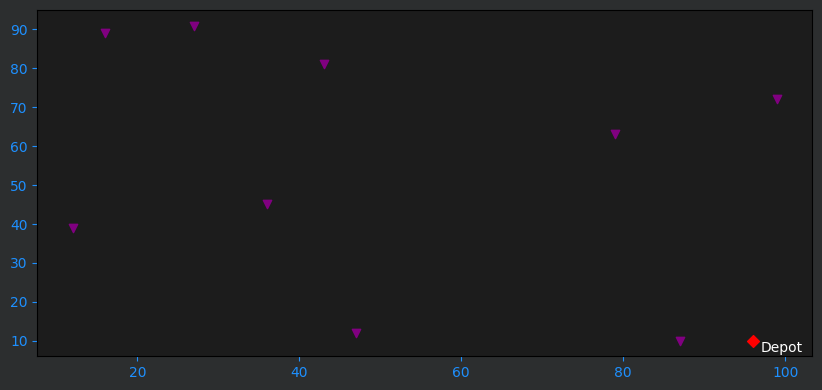

In [13]:
graficar_problema(nodes)

In [14]:
labels = clusterizar(epsilon,min_samples)


In [15]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [16]:
best_paths,best_distances,clusters_unicos,c_demanda,c_nodes = estructurar_clusters(labels)

In [17]:
demanda_optima,nodos_optimos,labels_optimos = c_optimos(c_demanda,c_nodes,epsilon,min_samples)

In [18]:
nodos_optimos

{0: [0, 8], 1: [0, 5, 9], 2: [0, 3, 1, 2, 4], 3: [0, 6, 7]}

In [20]:
distance_matrix

,0,1,2,3,4,5,6,7,8,9
0,0.000000,88.865066,112.432202,49.040799,106.404887,88.600226,55.659680,62.072538,9.000000,69.462220
1,88.865066,0.000000,50.159745,44.204072,54.120237,52.201533,71.168813,93.048375,80.411442,24.738634
2,112.432202,50.159745,0.000000,83.006024,11.180340,28.160256,68.154237,84.723078,106.216760,48.332184
3,49.040799,44.204072,83.006024,0.000000,81.492331,69.115845,60.207973,79.397733,40.049969,34.785054
4,106.404887,54.120237,11.180340,81.492331,0.000000,18.867962,59.059292,74.464757,100.801786,46.872167
5,88.600226,52.201533,28.160256,69.115845,18.867962,0.000000,40.249224,56.718604,83.528438,36.674242
6,55.659680,71.168813,68.154237,60.207973,59.059292,40.249224,0.000000,21.931712,53.600373,46.615448
7,62.072538,93.048375,84.723078,79.397733,74.464757,56.718604,21.931712,0.000000,63.150614,68.541958
8,9.000000,80.411442,106.216760,40.049969,100.801786,83.528438,53.600373,63.150614,0.000000,61.854668
9,69.462220,24.738634,48.332184,34.785054,46.872167,36.674242,46.615448,68.541958,61.854668,0.000000


In [19]:
c_matriz = []
for cluster in nodos_optimos.values():
    m = np.zeros((len(cluster),len(cluster)))
    for i in range(len(cluster)):
        for j in range(len(cluster)):
            m[i][j] = distance_matrix[cluster[i]][cluster[j]]
    c_matriz.append(m)
c_matriz


[array([[0., 9.],
        [9., 0.]]),
 array([[ 0.        , 88.60022573, 69.46221995],
        [88.60022573,  0.        , 36.67424164],
        [69.46221995, 36.67424164,  0.        ]]),
 array([[  0.        ,  49.04079934,  88.86506625, 112.43220179,
         106.40488711],
        [ 49.04079934,   0.        ,  44.20407221,  83.00602388,
          81.49233093],
        [ 88.86506625,  44.20407221,   0.        ,  50.15974482,
          54.12023651],
        [112.43220179,  83.00602388,  50.15974482,   0.        ,
          11.18033989],
        [106.40488711,  81.49233093,  54.12023651,  11.18033989,
           0.        ]]),
 array([[ 0.        , 55.6596802 , 62.07253821],
        [55.6596802 ,  0.        , 21.9317122 ],
        [62.07253821, 21.9317122 ,  0.        ]])]

In [21]:
resultados = {}
td = 0
final_path = []
for i in range(len(c_matriz)):
    path,distance = aco(c_matriz[i])
    for p in path:
        final_path.append(nodos_optimos[i][p])
    resultados[str(final_path)] = distance
    final_path = []
    td += distance

resultados["Distancia total"] = td

C:\Users\jhost\AppData\Local\Temp\ipykernel_19608\306382276.py:5: RuntimeWarning: divide by zero encountered in divide
  neta = 1/d
C:\Users\jhost\AppData\Local\Temp\ipykernel_19608\306382276.py:27: RuntimeWarning: invalid value encountered in divide
  p = w/sum(w)


## **resultados**

<!-- 949.9646572727152
820.7748855175732
669.8921789240044
669.8921789240044
613.3904612943021
700.592067562538
732.417313108826
643.2278112834713
643.2278112834713
643.2278112834713
643.2278112834713
654.5983835723416
816.3888144398749
564.4392312035721
488.1214705440268
437.80935728701127
339.8806639512759
350.9581653684131
335.7377038818937 -->

{'[0, 8, 0]': 18.0,
 '[0, 9, 5, 0]': 194.73668732238028,
 '[0, 4, 2, 1, 3, 0]': 260.98984336080355,
 '[0, 7, 6, 0]': 139.66393061111827,
 'Distancia total': 613.3904612943021}

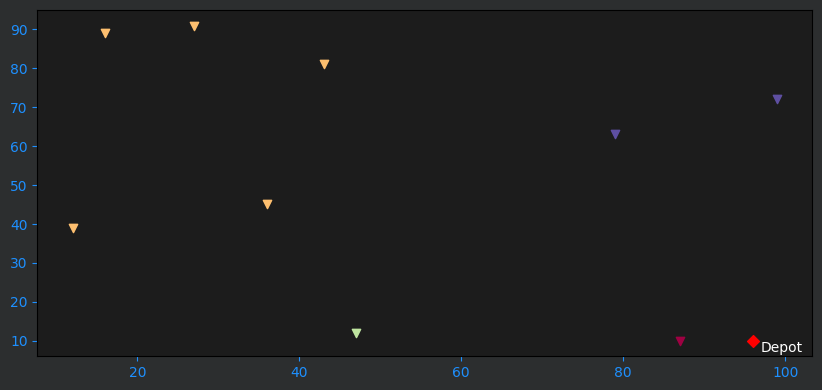

In [22]:
graficar_clusters(nodes,labels_optimos)
resultados

In [23]:
demanda_optima

{0: [0, 40], 1: [0, 24, 36], 2: [0, 18, 10, 18, 20], 3: [0, 19, 39]}

In [24]:
for i in range(4):
 print(sum(demanda_optima[i]) > capacity)    

False
False
False
False
